In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings("ignore")

In [5]:
sepsis_df = pd.read_csv("SyntheticData_Training.csv") 
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
sepsis_df

,studyid_adm,agecalc_adm,height_cm_adm,weight_kg_adm,muac_mm_adm,hr_bpm_adm,rr_brpm_app_adm,sysbp_mmhg_adm,diasbp_mmhg_adm,temp_c_adm,...,cookloc_adm,lightfuel_adm,tobacco_adm,bednet_adm,hctpretransfusion_adm,hivstatus_adm,malariastatuspos_adm,lengthadm,caregiver_adm_new,inhospital_mortality
0,1,16.8,79.8,11.6,150.0,130.0,23.0,92.0,54.0,36.3,...,In a separate building/building space used as ...,Electric bulbs (national grid),Never,Always,Yes,HIV negative,No,2,Mother,0
1,2,46.1,93.0,13.6,151.0,115.0,35.0,72.0,42.0,36.8,...,In a separate building/building space used as ...,Tadooba,Never,Always,Yes,HIV negative,Yes,5,Mother,0
2,3,7.9,68.2,8.2,148.0,150.0,56.0,94.0,51.0,37.2,...,In a separate building/building space used as ...,Tadooba,Never,Always,Yes,HIV negative,No,4,Mother,0
3,4,38.2,95.0,12.0,138.0,134.0,38.0,94.0,57.0,37.6,...,In the house where you sleep,Electric bulbs (national grid),Never,Always,NaN,HIV negative,Yes,5,Mother,0
4,5,16.1,83.0,12.0,165.0,163.0,61.0,107.0,73.0,38.7,...,Outdoors in the open,Electric bulbs (national grid),Never,Sometimes,Yes,HIV negative,Yes,7,Mother,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,2682,20.1,98.2,10.0,135.0,163.0,61.0,103.0,54.0,39.6,...,Outdoors in the open,Solar powered bulbs,Never,Always,Yes,HIV negative,No,3,Mother,0
2682,2683,26.8,82.3,10.0,140.0,115.0,37.0,83.0,50.0,37.1,...,Outdoors in the open,Electric bulbs (national grid),Never,Sometimes,NaN,HIV negative,No,3,Mother,0
2683,2684,14.6,82.4,12.7,145.0,150.0,40.0,93.0,35.0,38.5,...,In a separate building/building space used as ...,Electric bulbs (national grid),Never,Always,Yes,HIV negative,Yes,2,Mother,0
2684,2685,9.5,67.5,7.5,130.0,145.0,26.0,88.0,52.0,37.3,...,In a separate building/building space used as ...,Solar powered bulbs,Never,Always,Yes,HIV negative,No,4,Mother,0


In [7]:
sepsis_df.info()
pd.set_option('display.max_rows', None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Columns: 138 entries, studyid_adm to inhospital_mortality
dtypes: float64(23), int64(3), object(112)
memory usage: 2.8+ MB


In [9]:
sepsis_df.duplicated().sum()

0

In [11]:
sepsis_df.duplicated().sum()

0

In [13]:
#Create a summary DataFrame of column characteristics

column_summary= pd.DataFrame({'Column': sepsis_df.columns, 
                              'Data Type': sepsis_df.dtypes.values,
                              'Missing Values': sepsis_df.isnull().sum().values,
                              'Missing %': (sepsis_df.isnull().mean() * 100).values,
                              'Unique Values': sepsis_df.nunique().values})



# Display all rows in the column summary
pd.set_option('display.max_rows', None)

# Print
print(column_summary)

                       Column Data Type  Missing Values  Missing %  \
0                 studyid_adm     int64               0   0.000000   
1                 agecalc_adm   float64               0   0.000000   
2               height_cm_adm   float64              14   0.521221   
3               weight_kg_adm   float64               9   0.335071   
4                 muac_mm_adm   float64              13   0.483991   
5                  hr_bpm_adm   float64               1   0.037230   
6             rr_brpm_app_adm   float64               5   0.186150   
7              sysbp_mmhg_adm   float64               2   0.074460   
8             diasbp_mmhg_adm   float64               1   0.037230   
9                  temp_c_adm   float64               1   0.037230   
10       spo2site1_pc_oxi_adm   float64               4   0.148920   
11       spo2site2_pc_oxi_adm   float64             205   7.632167   
12              spo2other_adm   float64            2505  93.261355   
13                 m

In [15]:
# Removing leading/trailing whitespace
sepsis_df.columns = sepsis_df.columns.str.strip()

# Define the intervention columns we want to drop
intervention_cols = [f"admitabx_adm___{i}" for i in range(1, 22)]

# Dropping them
sepsis_df.drop(columns=intervention_cols, inplace=True, errors='ignore')

# Confirming
print("Remaining columns:", sepsis_df.shape[1])
print("Dropped intervention columns:", intervention_cols)


Remaining columns: 117
Dropped intervention columns: ['admitabx_adm___1', 'admitabx_adm___2', 'admitabx_adm___3', 'admitabx_adm___4', 'admitabx_adm___5', 'admitabx_adm___6', 'admitabx_adm___7', 'admitabx_adm___8', 'admitabx_adm___9', 'admitabx_adm___10', 'admitabx_adm___11', 'admitabx_adm___12', 'admitabx_adm___13', 'admitabx_adm___14', 'admitabx_adm___15', 'admitabx_adm___16', 'admitabx_adm___17', 'admitabx_adm___18', 'admitabx_adm___19', 'admitabx_adm___20', 'admitabx_adm___21']


In [33]:
# Step 2: Clinical hierarchy imputation
impute_order = [
    'lactate_mmolpl_adm',    # Most critical first
    'hematocrit_gpdl_adm',
    'spo2site1_pc_oxi_adm',
    'hr_bpm_adm',
    'muac_mm_adm'
]
for var in impute_order:
    sepsis_df[var] = sepsis_df.groupby('respdistress_adm')[var].transform(
        lambda x: x.fillna(x.median()))

# Step 3: Special handling for meaningful missingness
sepsis_df['hivstatus_adm'] = sepsis_df['hivstatus_adm'].fillna('NotTested')
sepsis_df['bcseye_adm'] = sepsis_df['bcseye_adm'].fillna('NoResponse')

In [41]:
# Select only numeric clinical predictors
clinical_num = sepsis_df[['lactate_mmolpl_adm', 'hematocrit_gpdl_adm', 
                         'sysbp_mmhg_adm', 'hr_bpm_adm']].copy()

# Convert to numpy array for imputation
clinical_array = clinical_num.values

In [59]:
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=50, random_state=42),
    max_iter=20,  # Increased from 10 for better convergence
    tol=0.01,     # Relax tolerance to avoid warning
    random_state=42
)

# Impute and return to DataFrame
imputed_array = imputer.fit_transform(clinical_array)
clinical_num_imputed = pd.DataFrame(
    imputed_array, 
    columns=clinical_num.columns,
    index=clinical_num.index
)

In [45]:
# Update only the imputed columns in original DataFrame
sepsis_df.update(clinical_num_imputed)

# Verify no more missing values
print(sepsis_df[['lactate_mmolpl_adm', 'hematocrit_gpdl_adm']].isna().sum())

lactate_mmolpl_adm     0
hematocrit_gpdl_adm    0
dtype: int64


In [51]:
# Neurological worst-case imputation
sepsis_df['bcseye_adm'] = sepsis_df['bcseye_adm'].fillna('NoResponse')
sepsis_df['bcsverbal_adm'] = sepsis_df['bcsverbal_adm'].fillna('NoVocalResponse')

In [67]:
# Social/demographic handling
sepsis_df['momagefirstpreg_adm'] = sepsis_df['momagefirstpreg_adm'].fillna(-1)  # Special value
sepsis_df['hivstatus_adm'] = sepsis_df['hivstatus_adm'].fillna('NotTested')

# MUAC imputation based on weight-for-age
sepsis_df['muac_mm_adm'] = sepsis_df.groupby(pd.qcut(sepsis_df['weight_kg_adm'], 5))['muac_mm_adm'].transform(
    lambda x: x.fillna(x.median()))

In [ ]:
# rename_columns = {
    # Patient Identifiers
    'studyid_adm': 'patient_id',
    
    # Demographics
    'agecalc_adm': 'age_months',
    'sex_adm': 'sex',
    'momage_adm': 'mother_age',
    'momagefirstpreg_adm': 'mother_age_first_pregnancy',
    'householdsize_adm': 'household_size',
    'alivechildren_adm': 'alive_children',
    'deadchildren_adm': 'dead_children',
    'caregiverage_adm': 'caregiver_age',
    'caregivermarried_adm': 'caregiver_married',
    'momalive_adm': 'mother_alive',
    'momageknown_adm': 'mother_age_known',
    'momagefirstpregknown_adm': 'mother_age_first_preg_known',
    'momedu_adm': 'mother_education',
    'momhiv_adm': 'mother_hiv_status',
    
    # Anthropometrics & Vitals
    'height_cm_adm': 'height_cm',
    'weight_kg_adm': 'weight_kg',
    'muac_mm_adm': 'muac_mm',
    'hr_bpm_adm': 'heart_rate_minute',
    'rr_brpm_app_adm': 'respiratory_rate_minute',
    'sysbp_mmhg_adm': 'systolic_bp',
    'diasbp_mmhg_adm': 'diastolic_bp',
    'temp_c_adm': 'temperature_c',
    'spo2site1_pc_oxi_adm': 'spo2_site1',
    'spo2site2_pc_oxi_adm': 'spo2_site2',
    'spo2other_adm': 'spo2_other',
    'spo2onoxy_adm': 'spo2_on_oxygen',
    'oxygenavail_adm': 'oxygen_available',
    'caprefill_adm': 'capillary_refill',
    
    # Labs
    'hematocrit_gpdl_adm': 'hematocrit',
    'lactate_mmolpl_adm': 'lactate',
    'lactate2_mmolpl_adm': 'lactate_2',
    'glucose_mmolpl_adm': 'glucose',
    'sqi1_perc_oxi_adm': 'signal_quality_index1',
    'sqi2_perc_oxi_adm': 'signal_quality_index2',
    'hctpretransfusion_adm': 'hct_pre_transfusion',
    
    # Clinical Signs & Symptoms
    'respdistress_adm': 'respiratory_distress',
    'bcseye_adm': 'eye_response',
    'bcsmotor_adm': 'motor_response',
    'bcsverbal_adm': 'verbal_response',
    'bcgscar_adm': 'bcg_scar',
    'priorweekabx_adm': 'antibiotics_prior_week',
    'priorweekantimal_adm': 'antimalarials_prior_week',
    'priorhosp_adm': 'prior_hospitalization',
    'prioryearwheeze_adm': 'wheezing_past_year',
    'prioryearcough_adm': 'cough_past_year',
    'diarrheaoften_adm': 'frequent_diarrhea',
    'tbcontact_adm': 'tb_contact',
    'feedingstatus_adm': 'feeding_status',
    'exclbreastfed_adm': 'exclusively_breastfed',
    'nonexclbreastfed_adm': 'non_exclusive_breastfed',
    'totalbreastfed_adm': 'total_breastfed',
    'badhealthduration_adm': 'illness_duration',
    
    # Vaccination History
    'vaccmeasles_adm': 'measles_vaccine',
    'vaccmeaslessource_adm': 'measles_vaccine_source',
    'vaccpneumoc_adm': 'pneumococcal_vaccine',
    'vaccpneumocsource_adm': 'pneumococcal_vaccine_source',
    'vaccdpt_adm': 'dpt_vaccine',
    'vaccdptsource_adm': 'dpt_vaccine_source',
    
    # Birth & Delivery
    'deliveryloc_adm': 'delivery_location',
    'birthattend_adm': 'birth_attendant',
    'duedateknown_adm': 'due_date_known',
    
    # Household & Environment
    'watersource_adm': 'water_source',
    'waterpure_adm': 'water_pure',
    'cookloc_adm': 'cooking_location',
    'lightfuel_adm': 'lighting_fuel',
    'tobacco_adm': 'tobacco_exposure',
    'bednet_adm': 'bednet_use',
    
    # Infectious Disease Status
    'hivstatus_adm': 'hiv_status',
    'malariastatuspos_adm': 'malaria_status',
    
    # Outcomes
    'inhospital_mortality': 'mortality',
    'lengthadm': 'length_of_stay',
    
    # Multi-choice Binary Variables (Symptoms, Comorbidities, etc.)
    # Symptoms
    'symptoms_adm___1': 'symptom_fever',
    'symptoms_adm___2': 'symptom_cough',
    'symptoms_adm___3': 'symptom_difficulty_breathing',
    'symptoms_adm___4': 'symptom_wheeze',
    'symptoms_adm___5': 'symptom_diarrhea',
    'symptoms_adm___6': 'symptom_vomiting',
    'symptoms_adm___7': 'symptom_convulsions',
    'symptoms_adm___8': 'symptom_lethargy',
    'symptoms_adm___9': 'symptom_unconsciousness',
    'symptoms_adm___10': 'symptom_ear_discharge',
    'symptoms_adm___11': 'symptom_skin_lesions',
    'symptoms_adm___12': 'symptom_poor_feeding',
    'symptoms_adm___13': 'symptom_irritability',
    'symptoms_adm___14': 'symptom_jaundice',
    'symptoms_adm___15': 'symptom_swollen_limbs',
    'symptoms_adm___16': 'symptom_abdominal_pain',
    'symptoms_adm___18': 'symptom_other',
    
    # Comorbidities
    'comorbidity_adm___1': 'comorbidity_prematurity',
    'comorbidity_adm___2': 'comorbidity_malnutrition',
    'comorbidity_adm___3': 'comorbidity_hiv',
    'comorbidity_adm___4': 'comorbidity_tb',
    'comorbidity_adm___5': 'comorbidity_heart_disease',
    'comorbidity_adm___6': 'comorbidity_chronic_lung',
    'comorbidity_adm___7': 'comorbidity_asthma',
    'comorbidity_adm___8': 'comorbidity_diabetes',
    'comorbidity_adm___9': 'comorbidity_renal',
    'comorbidity_adm___10': 'comorbidity_hypertension',
    'comorbidity_adm___11': 'comorbidity_seizures',
    'comorbidity_adm___12': 'comorbidity_other',
    
    # Birth Details
    'birthdetail_adm___1': 'birth_detail_preterm',
    'birthdetail_adm___2': 'birth_detail_low_birth_weight',
    'birthdetail_adm___3': 'birth_detail_csection',
    'birthdetail_adm___4': 'birth_detail_asphyxia',
    'birthdetail_adm___5': 'birth_detail_congenital',
    'birthdetail_adm___6': 'birth_detail_other',
    
    # Cooking Fuels (Multiple Options)
    'cookfuel_adm___1': 'cookfuel_wood',
    'cookfuel_adm___2': 'cookfuel_charcoal',
    'cookfuel_adm___3': 'cookfuel_kerosene',
    'cookfuel_adm___4': 'cookfuel_gas',
    'cookfuel_adm___5': 'cookfuel_electric',
    'cookfuel_adm___6': 'cookfuel_animal_dung',
    'cookfuel_adm___7': 'cookfuel_other',
    
    # Antibiotics on Admission (Multiple Options)
    'admitabx_adm___1': 'abx_ampicillin',
    'admitabx_adm___2': 'abx_gentamicin',
    'admitabx_adm___3': 'abx_ceftriaxone',
    'admitabx_adm___4': 'abx_amoxicillin',
    'admitabx_adm___5': 'abx_penicillin',
    'admitabx_adm___6': 'abx_cloxacillin',
    'admitabx_adm___7': 'abx_metronidazole',
    'admitabx_adm___8': 'abx_azithromycin',
    'admitabx_adm___9': 'abx_ciprofloxacin',
    'admitabx_adm___10': 'abx_doxycycline',
    'admitabx_adm___11': 'abx_erythromycin',
    'admitabx_adm___12': 'abx_vancomycin',
    'admitabx_adm___13': 'abx_meropenem',
    'admitabx_adm___14': 'abx_other',
    'admitabx_adm___15': 'abx_unknown',
    'admitabx_adm___16': 'abx_na',
    'admitabx_adm___17': 'abx_na2',
    'admitabx_adm___18': 'abx_na3',
    'admitabx_adm___19': 'abx_na4',
    'admitabx_adm___20': 'abx_na5',
    'admitabx_adm___21': 'abx_na6',
    
    # Miscellaneous
    'travelmethod_adm': 'travel_method',
    'traveldist_adm': 'travel_distance',
    'caregiver_adm_new': 'caregiver_id',
}

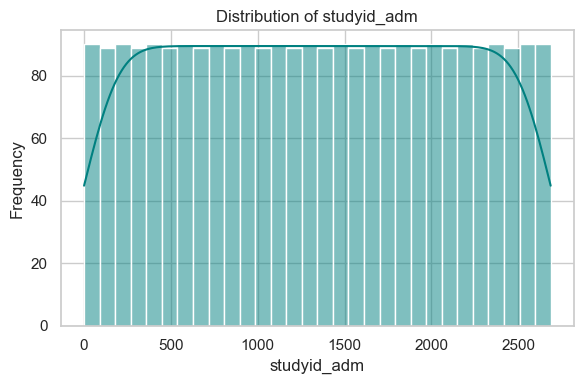

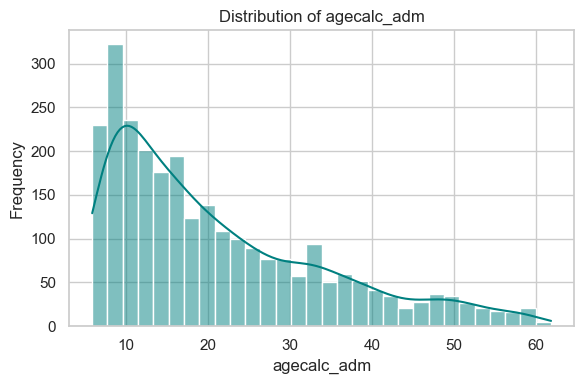

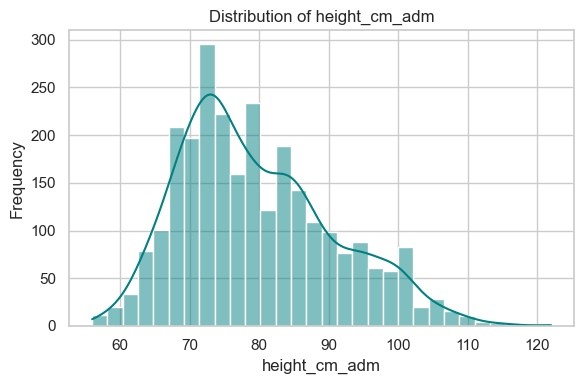

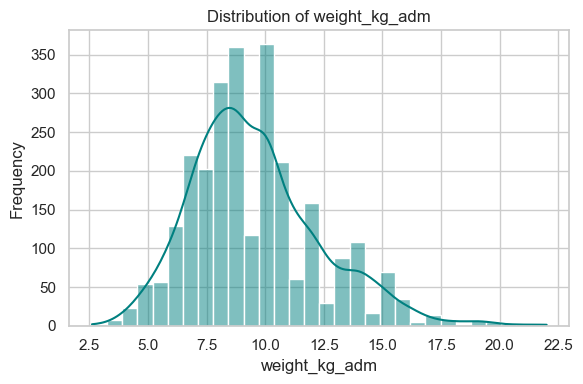

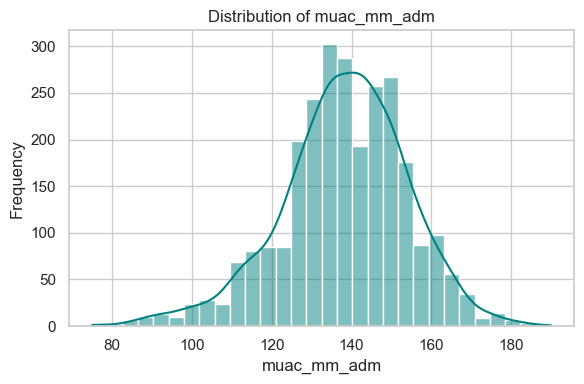

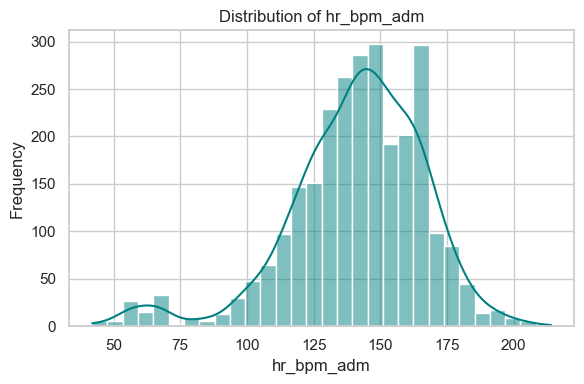

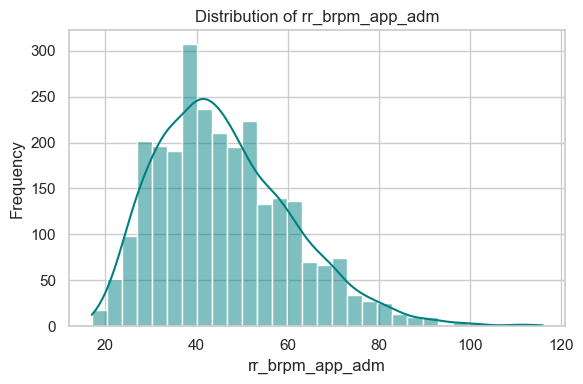

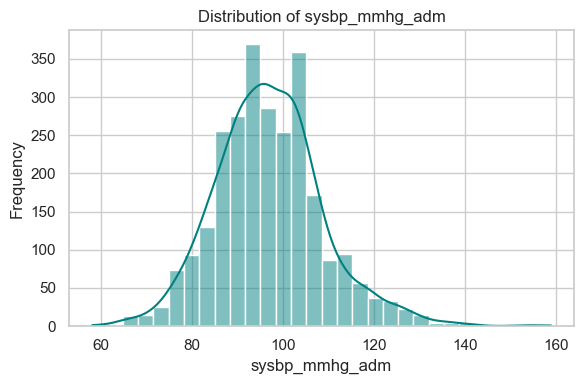

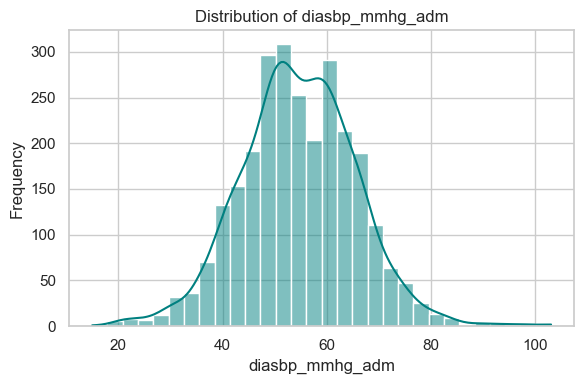

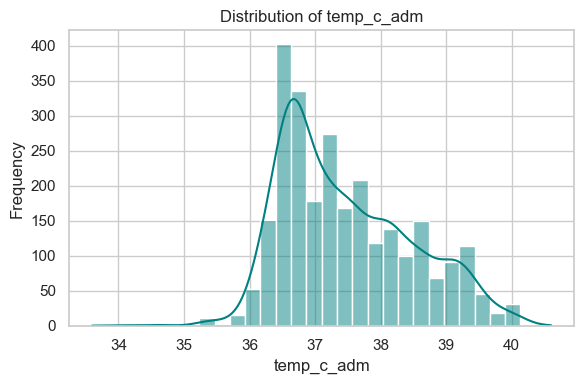

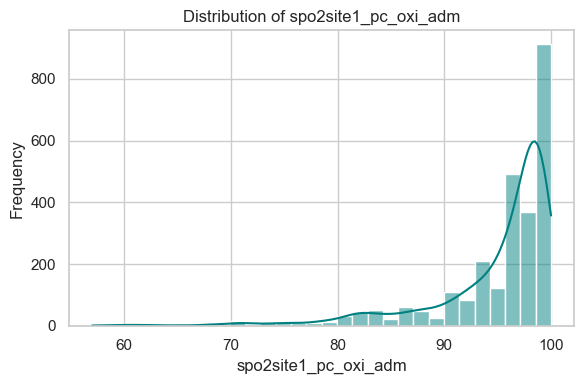

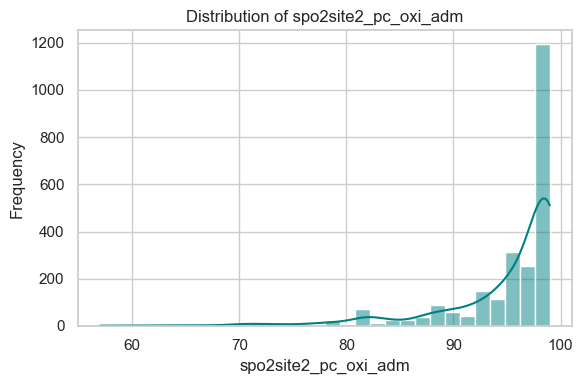

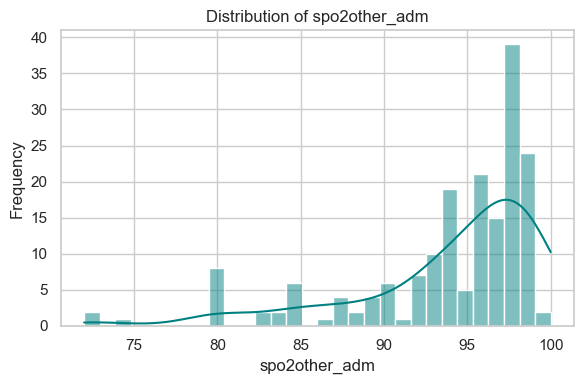

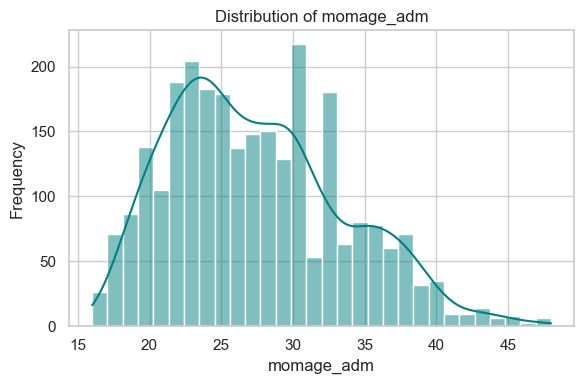

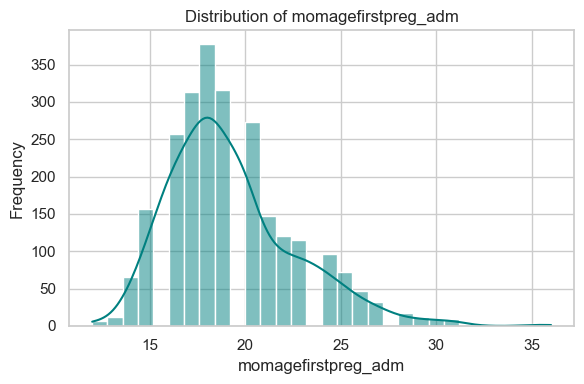

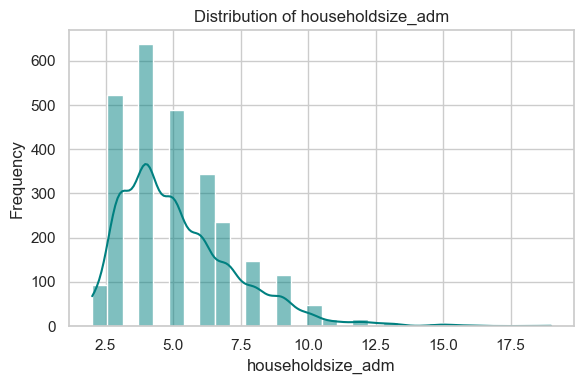

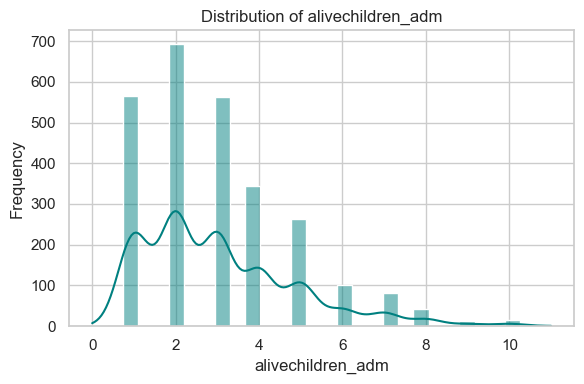

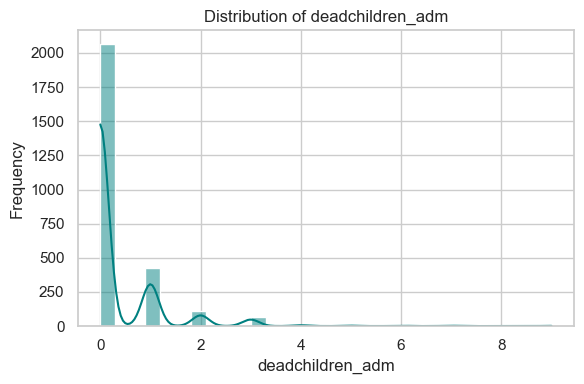

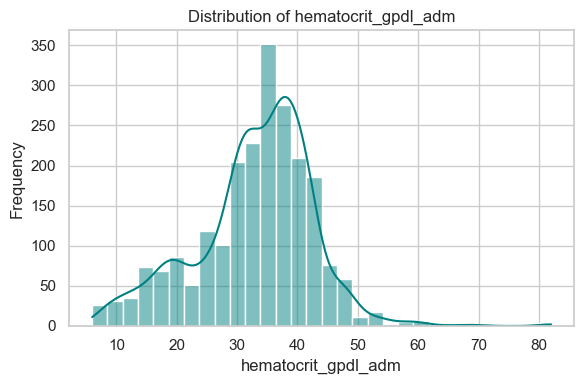

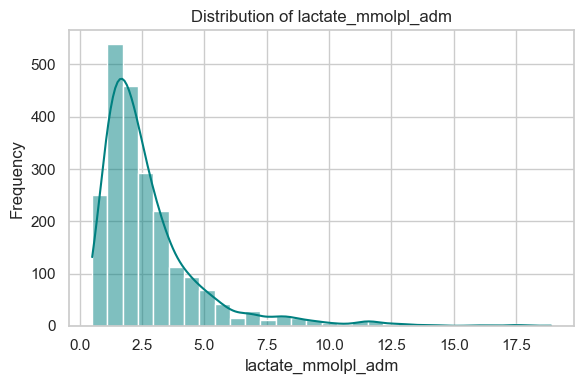

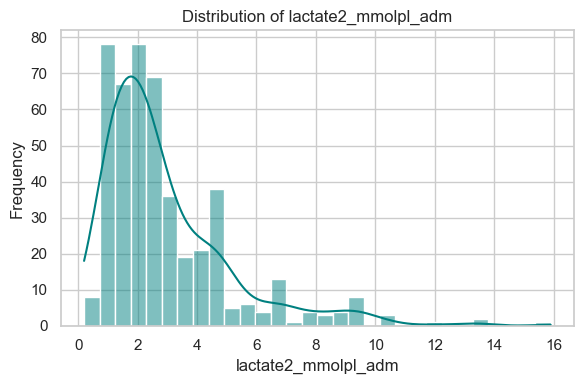

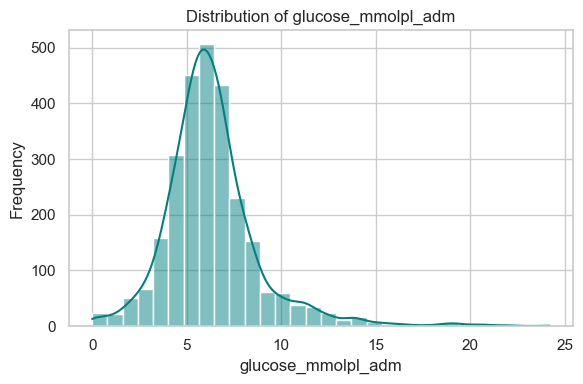

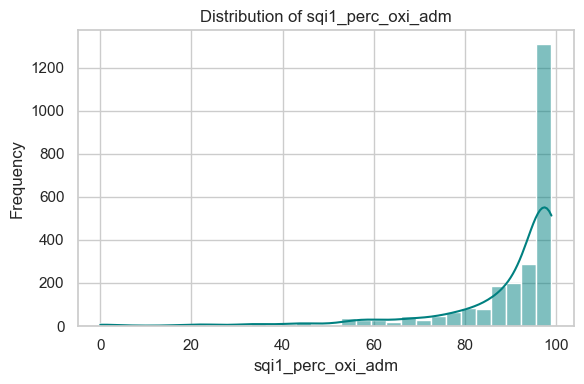

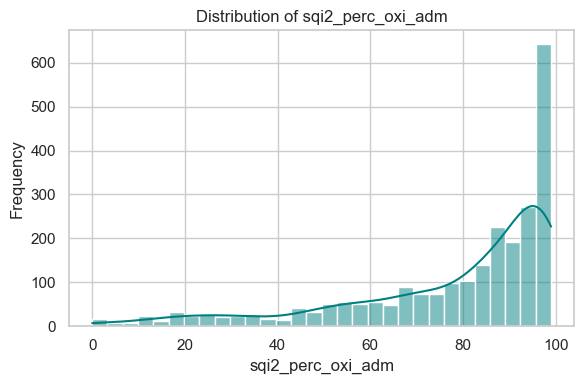

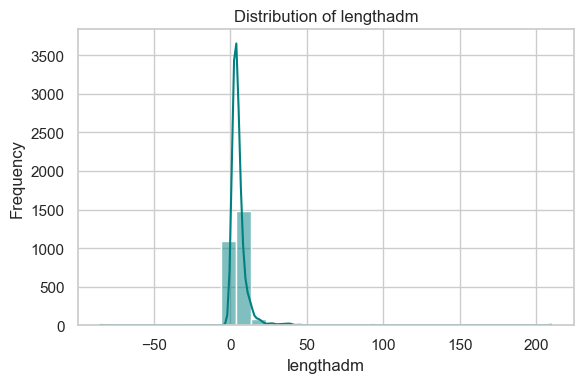

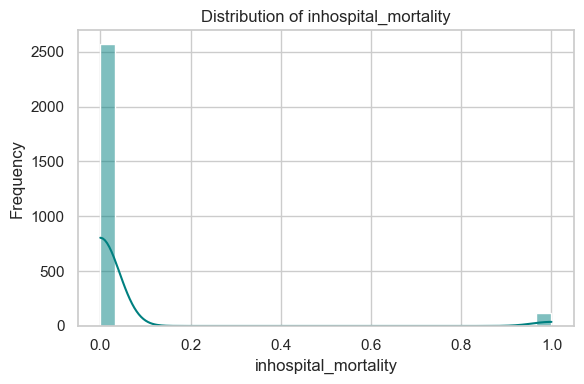

In [21]:
# Set a style
sns.set(style="whitegrid")

# Select numeric columns
num_cols = sepsis_df.select_dtypes(include=['float64', 'int64']).columns

# Plot histograms for numeric columns
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(sepsis_df[col], kde=True, bins=30, color='teal')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


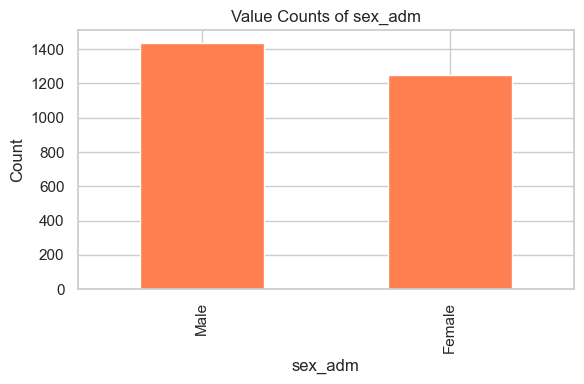

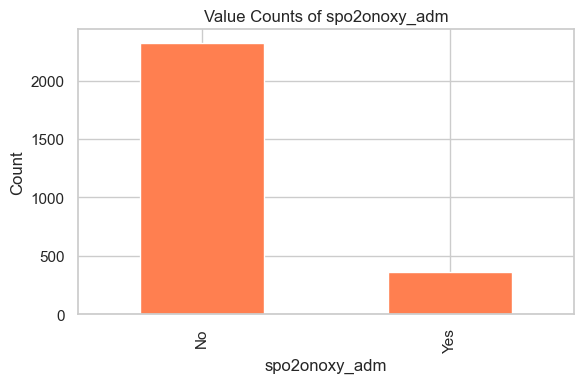

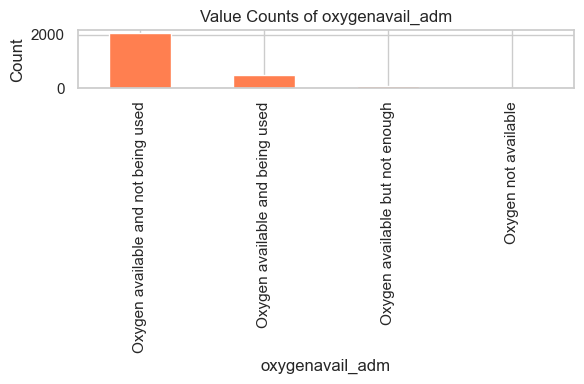

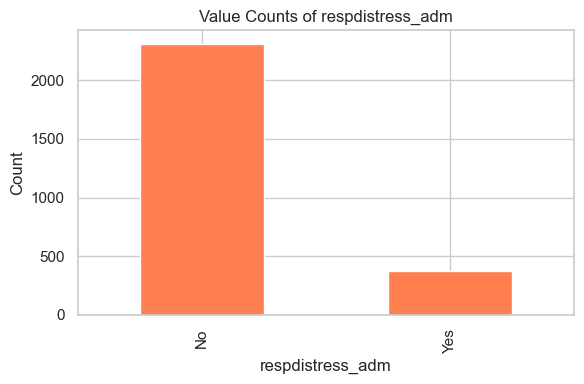

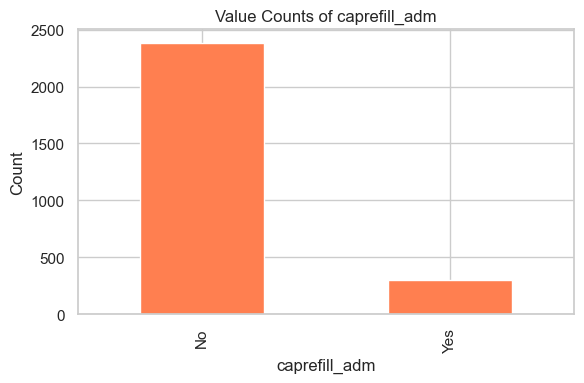

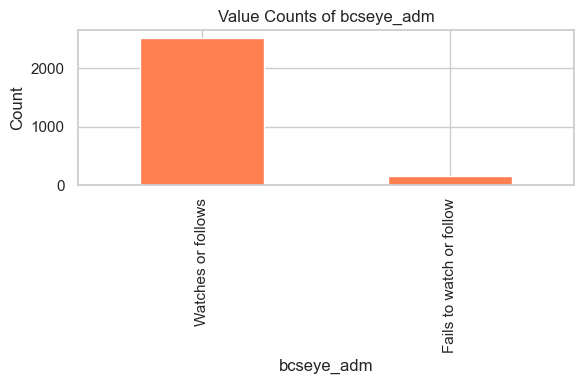

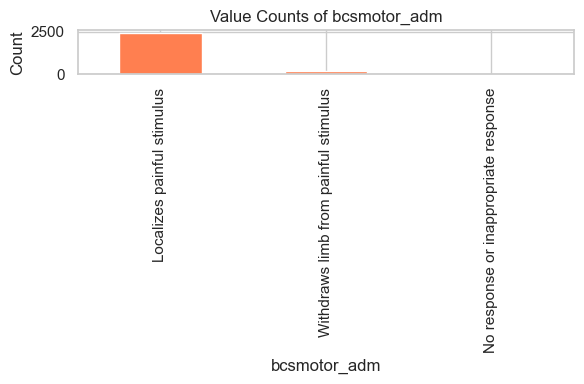

C:\Users\Hermela\AppData\Local\Temp\ipykernel_15664\43101538.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


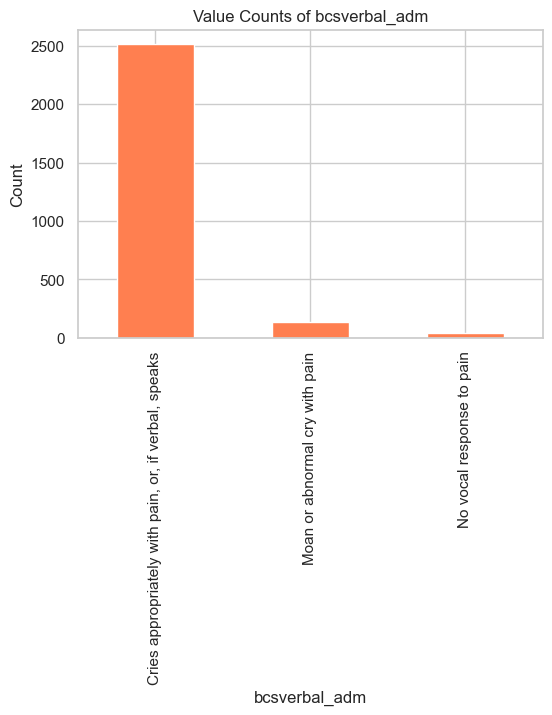

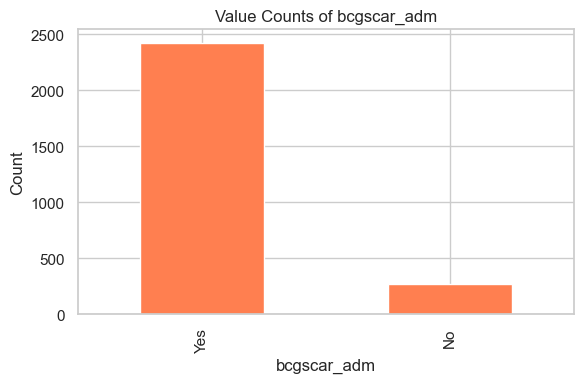

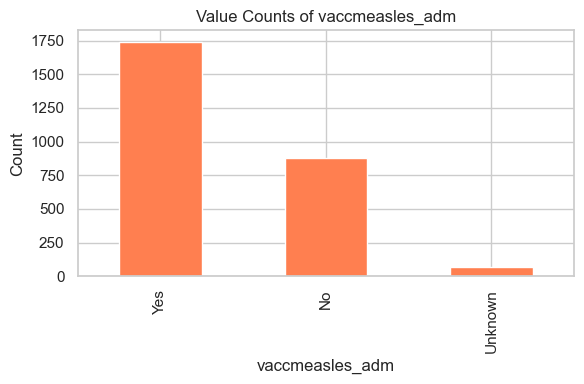

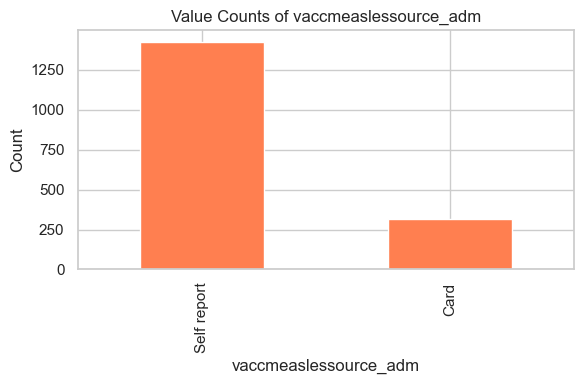

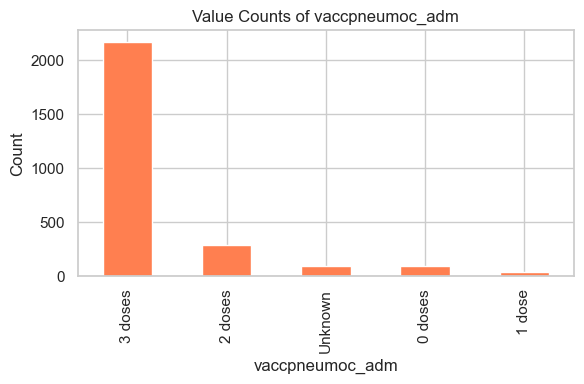

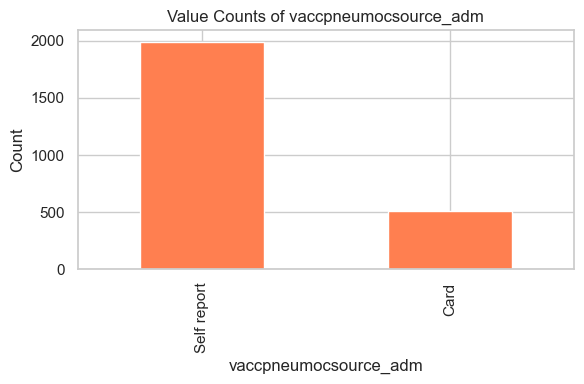

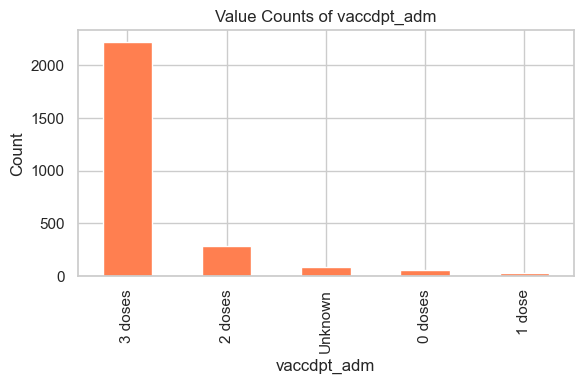

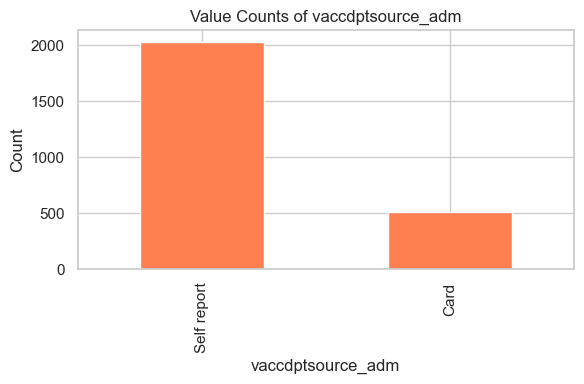

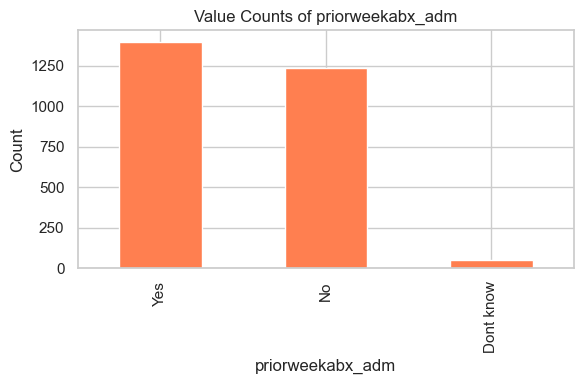

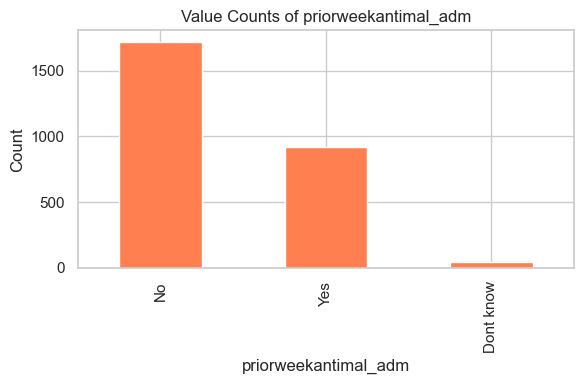

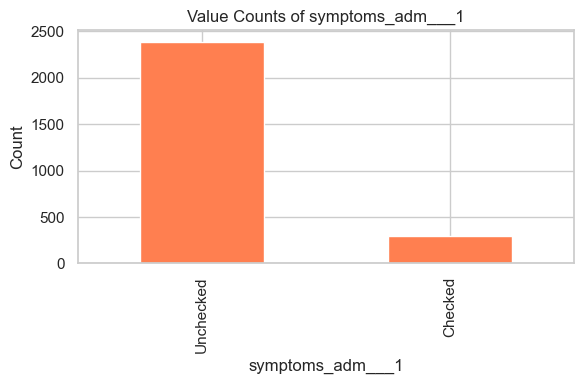

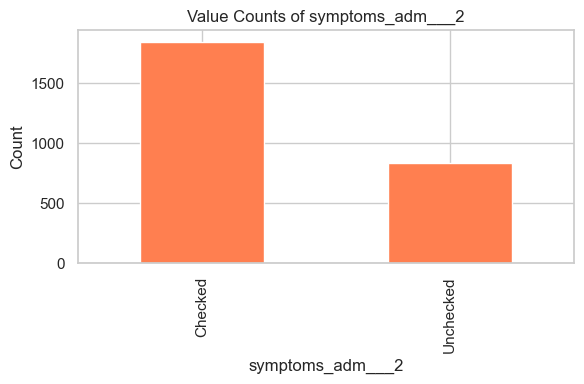

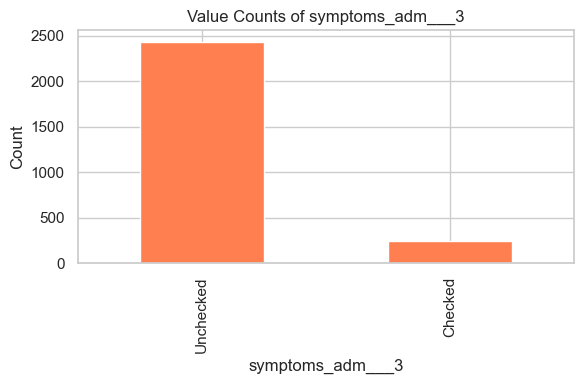

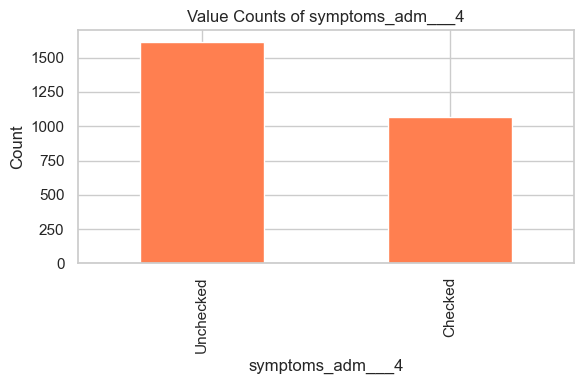

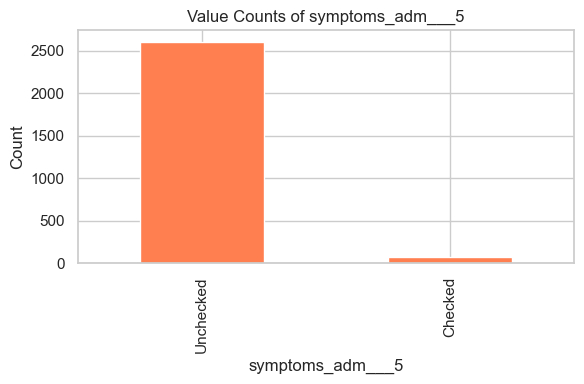

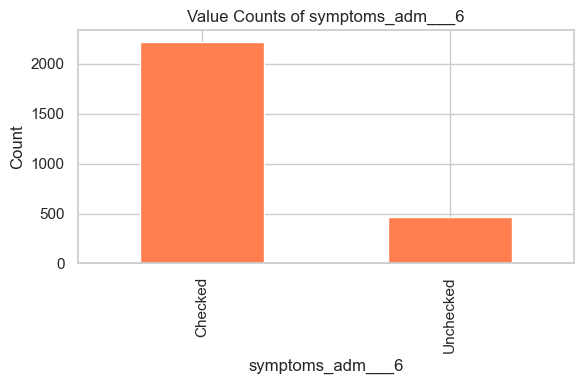

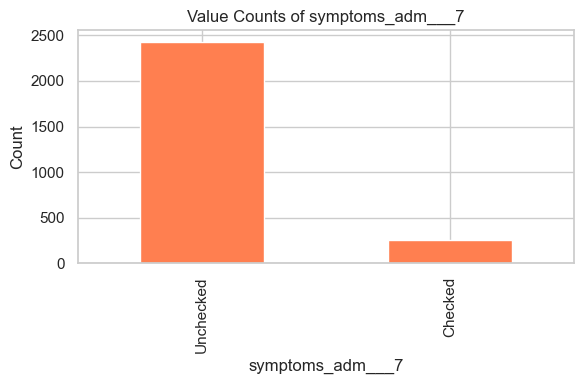

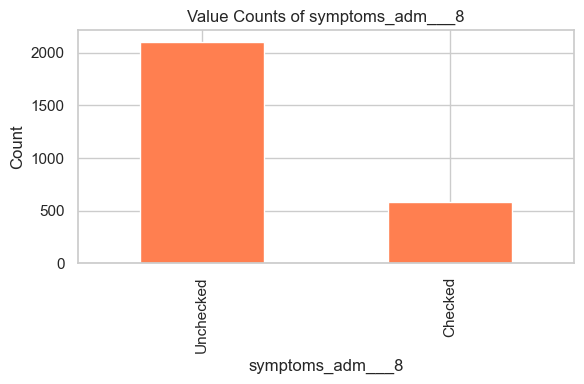

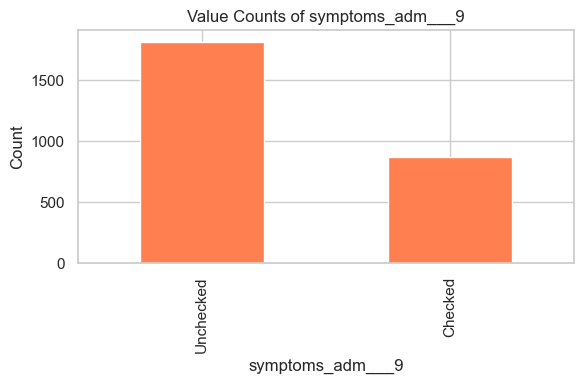

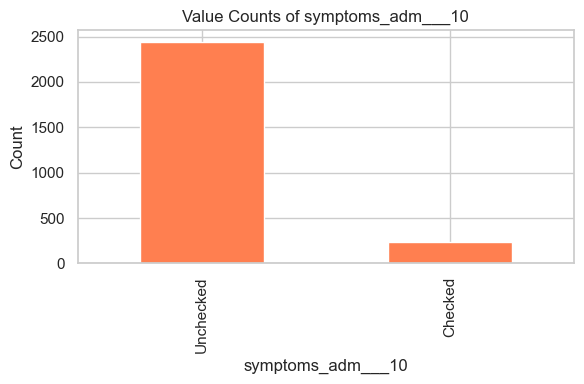

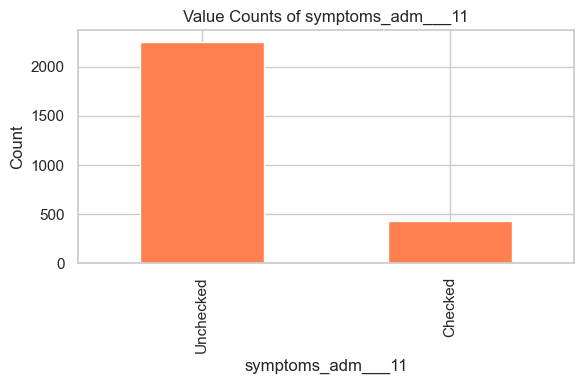

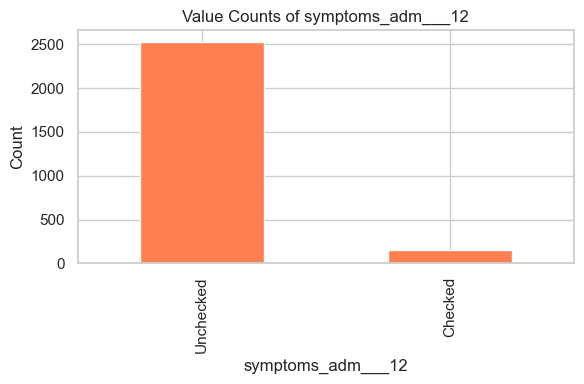

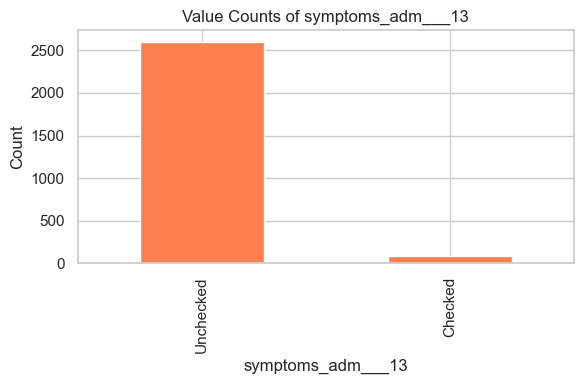

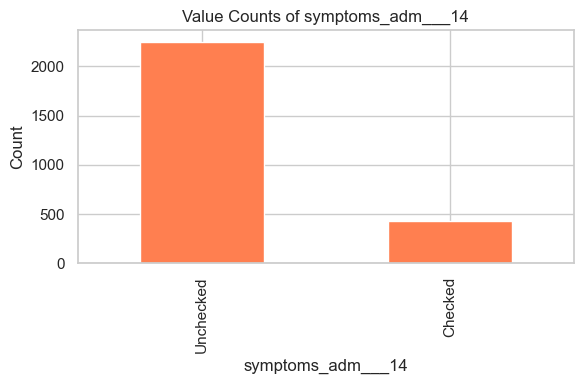

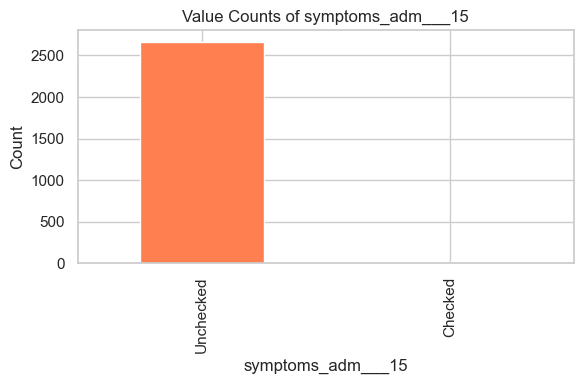

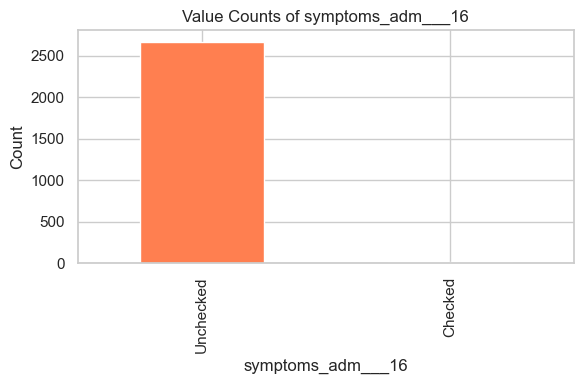

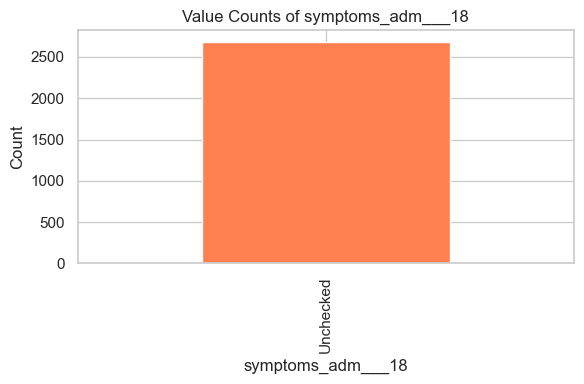

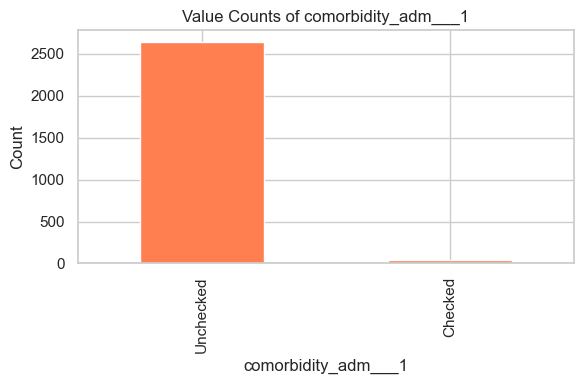

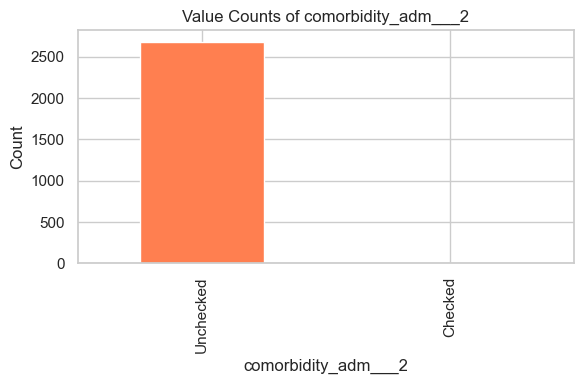

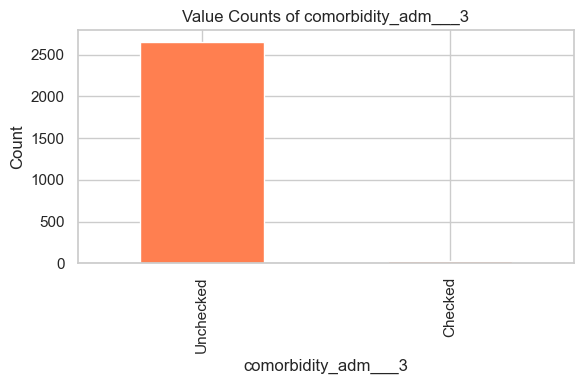

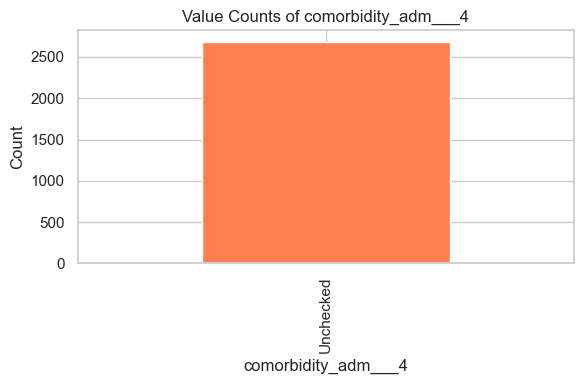

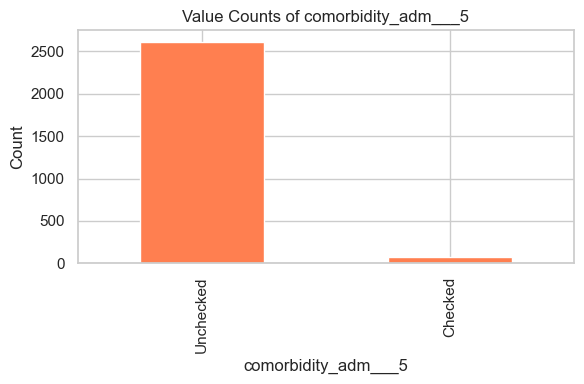

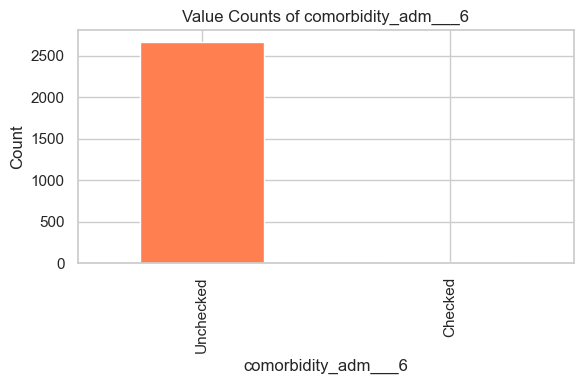

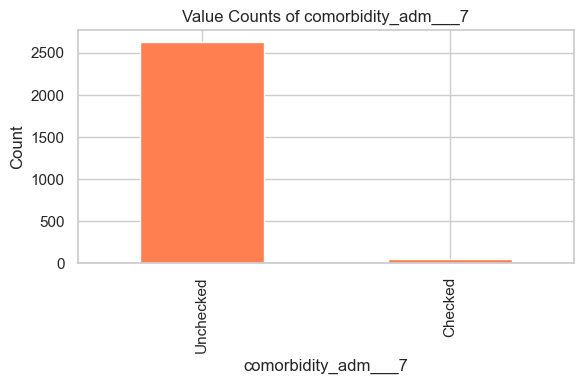

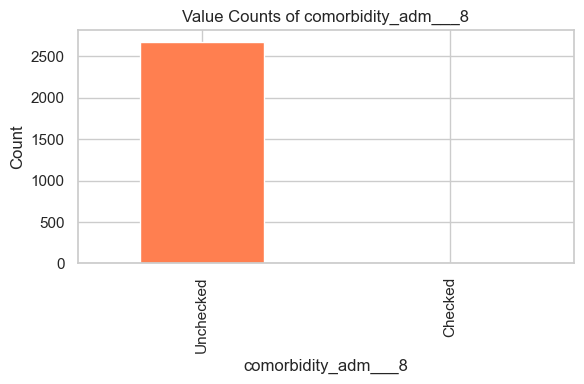

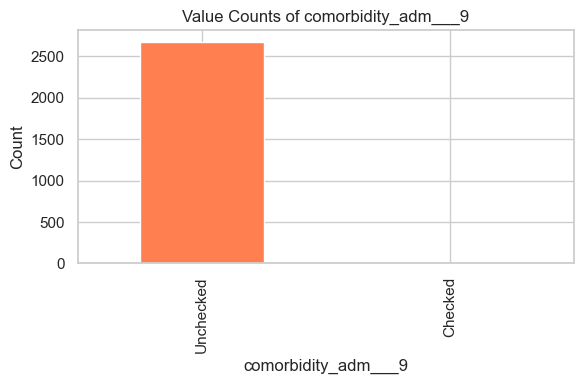

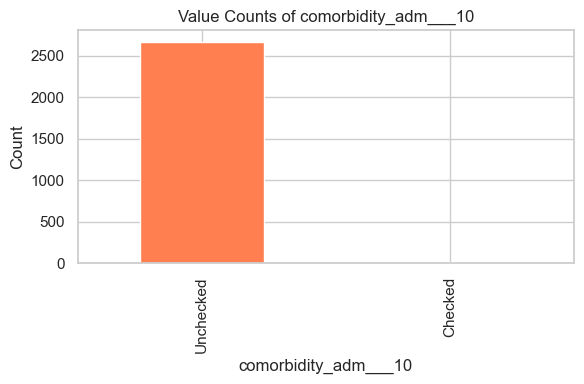

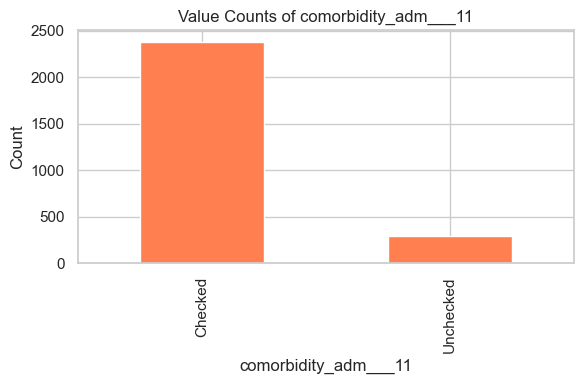

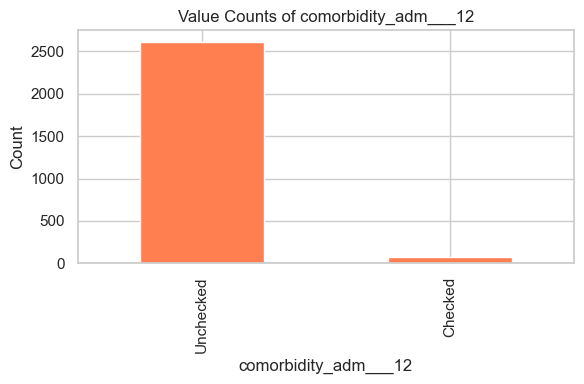

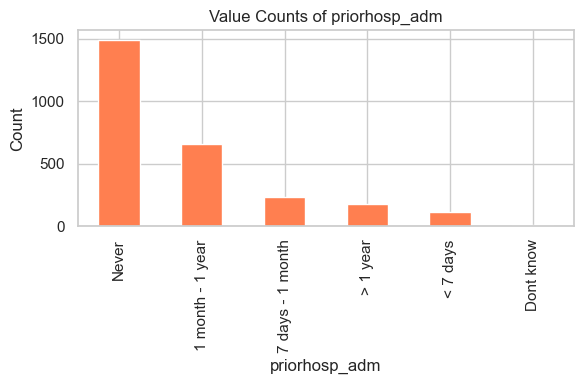

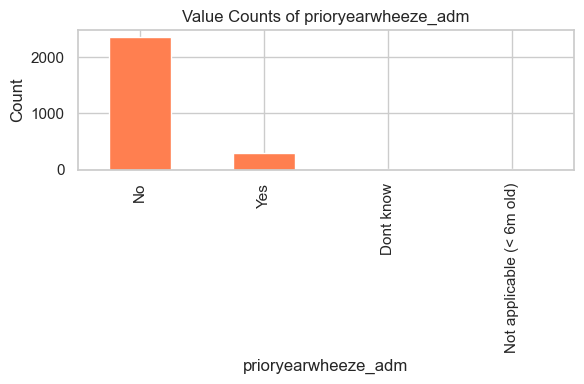

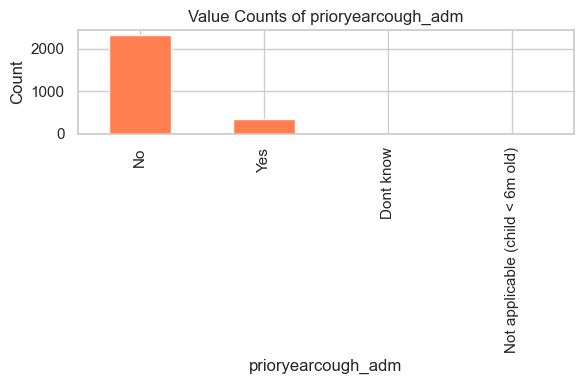

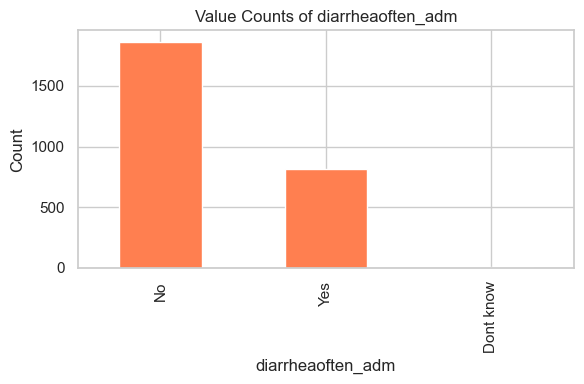

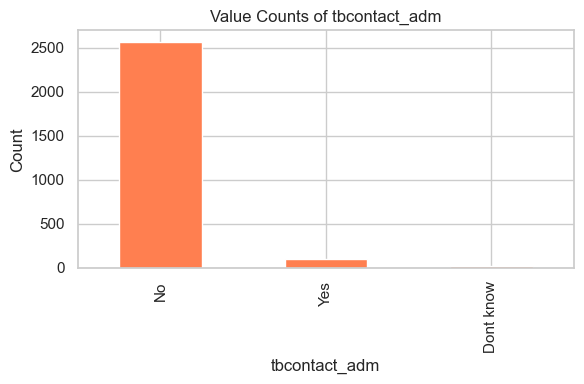

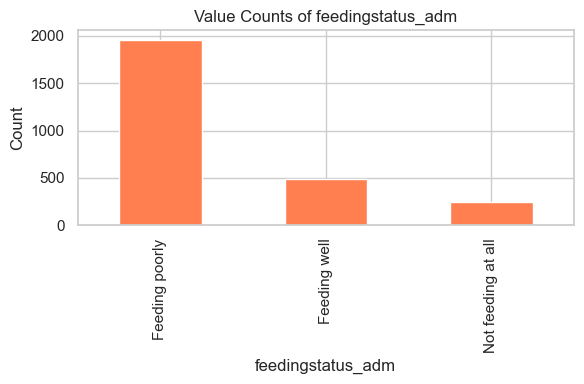

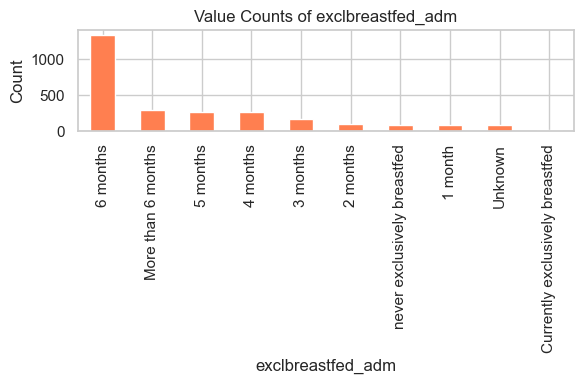

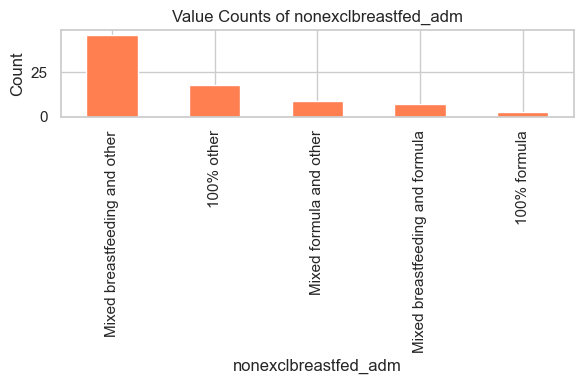

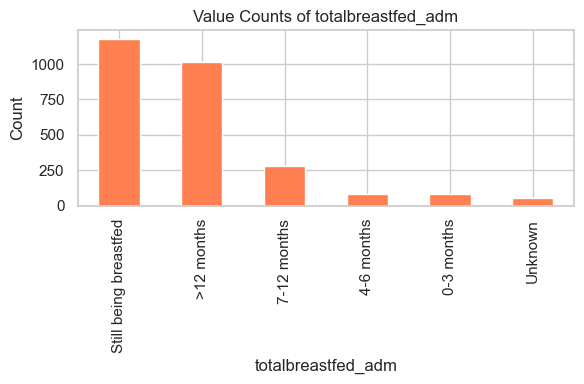

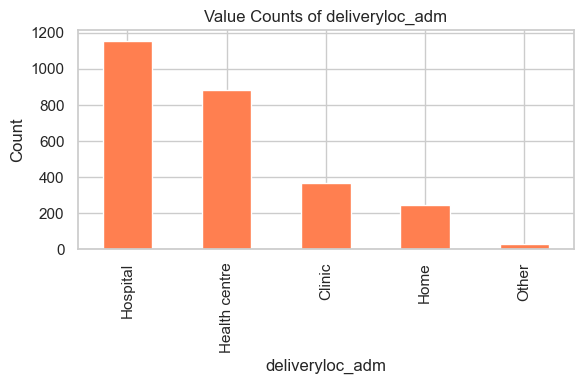

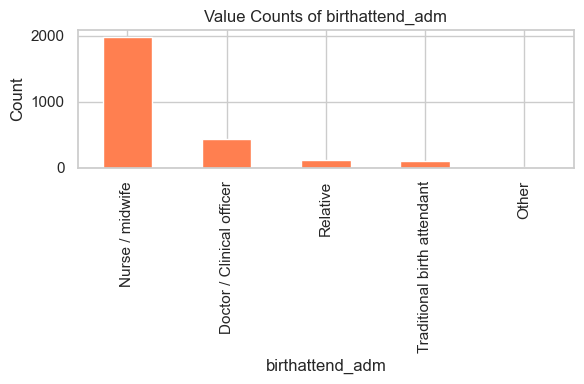

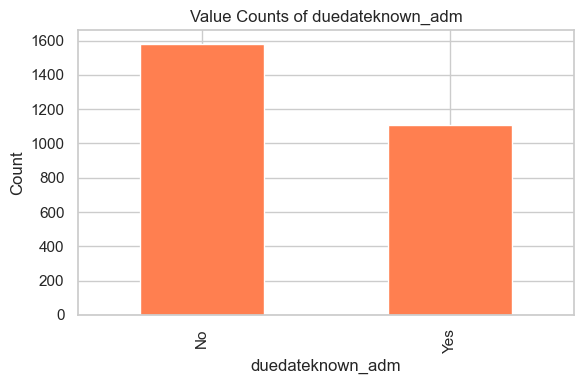

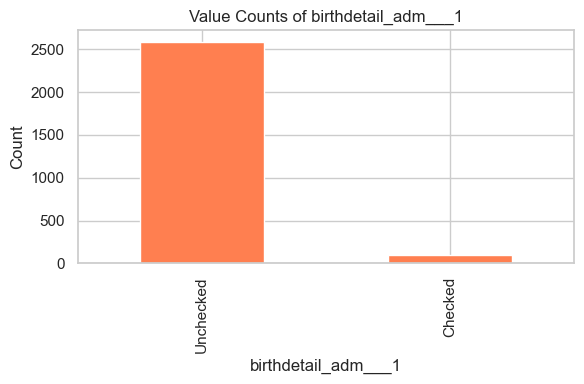

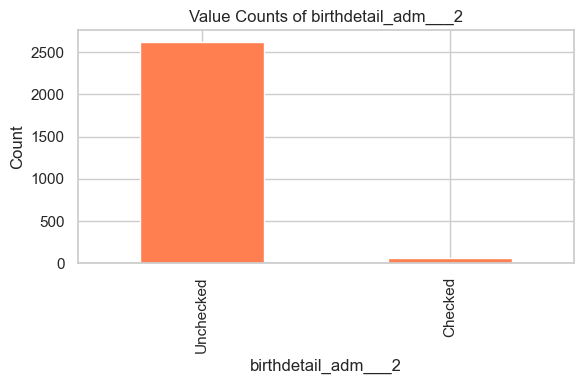

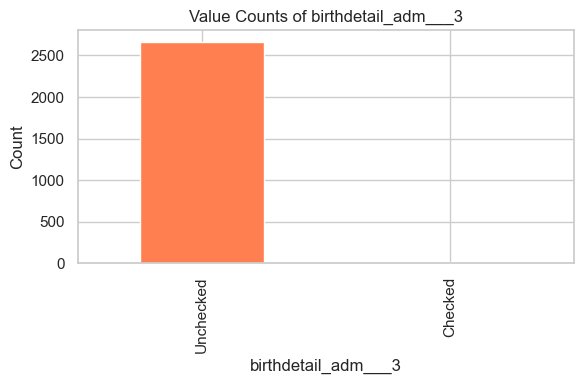

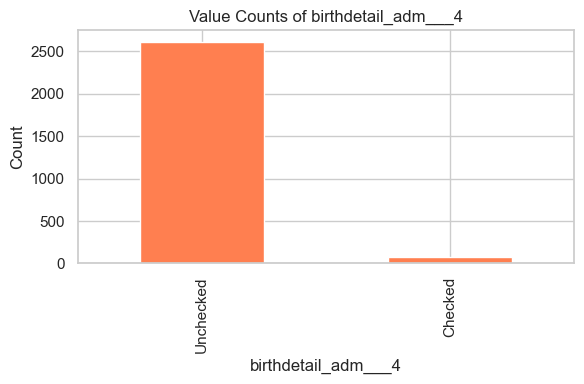

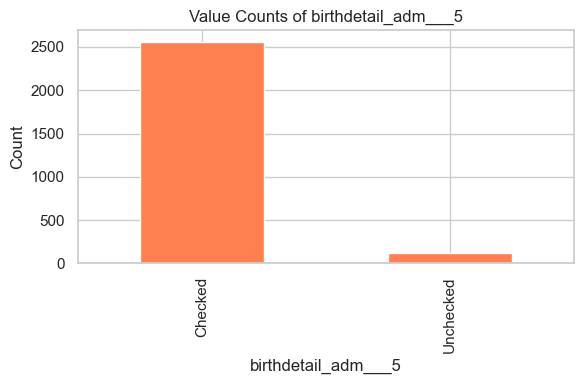

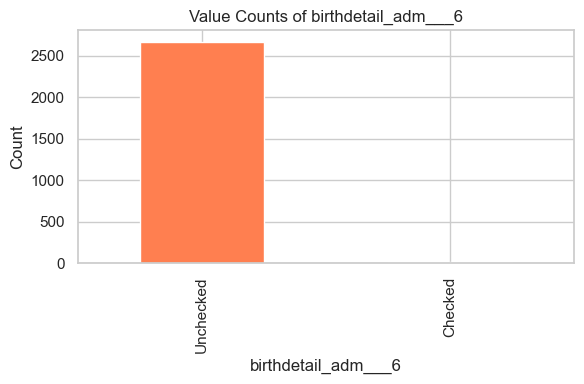

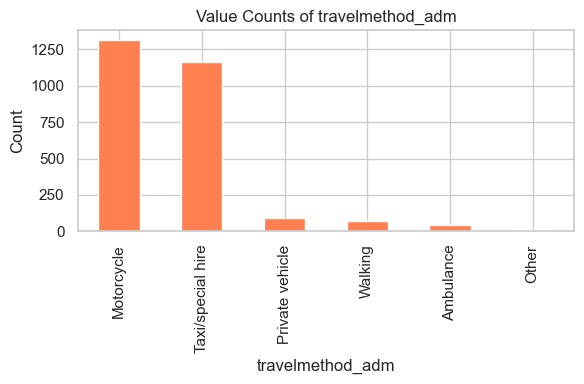

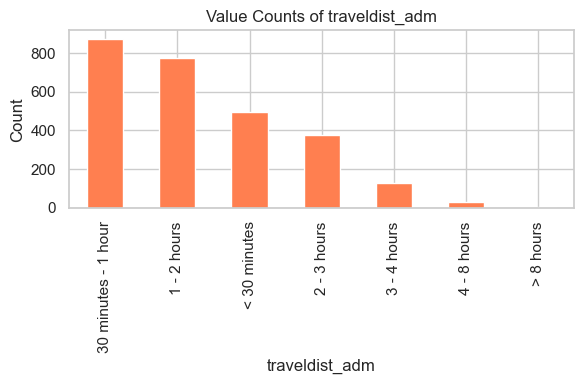

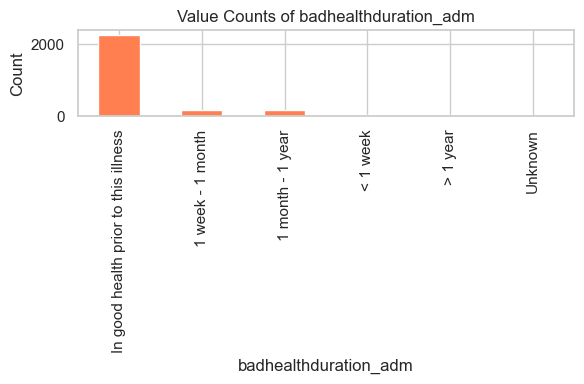

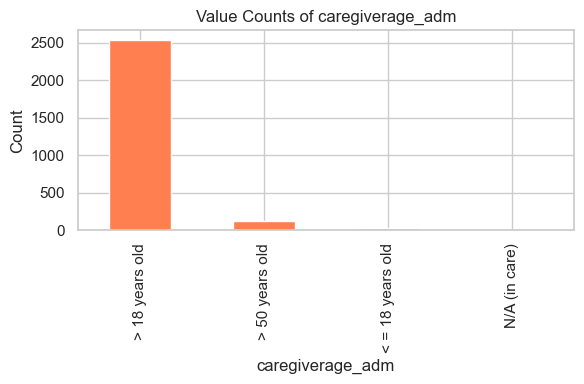

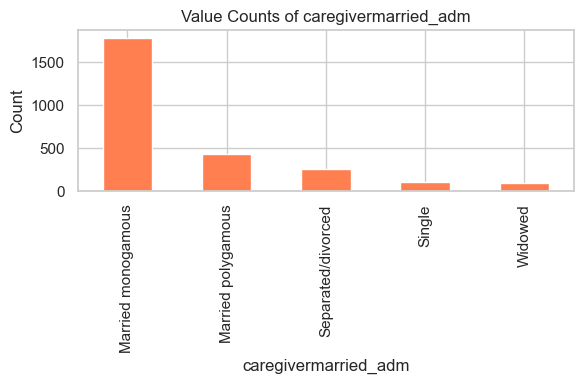

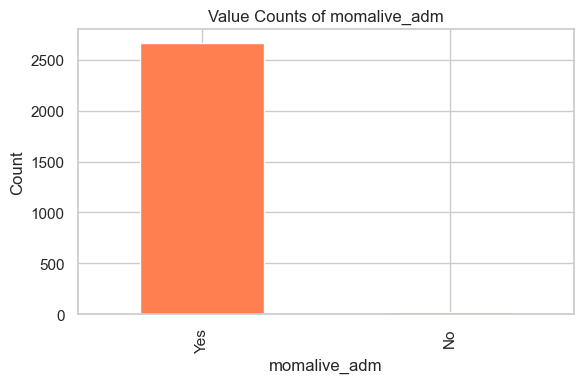

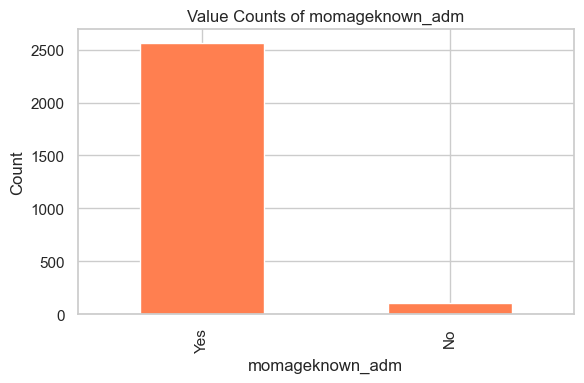

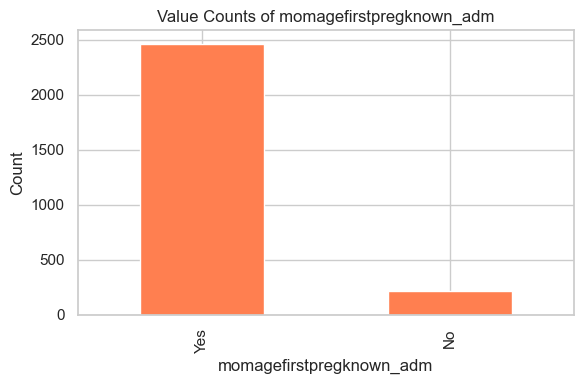

C:\Users\Hermela\AppData\Local\Temp\ipykernel_15664\43101538.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


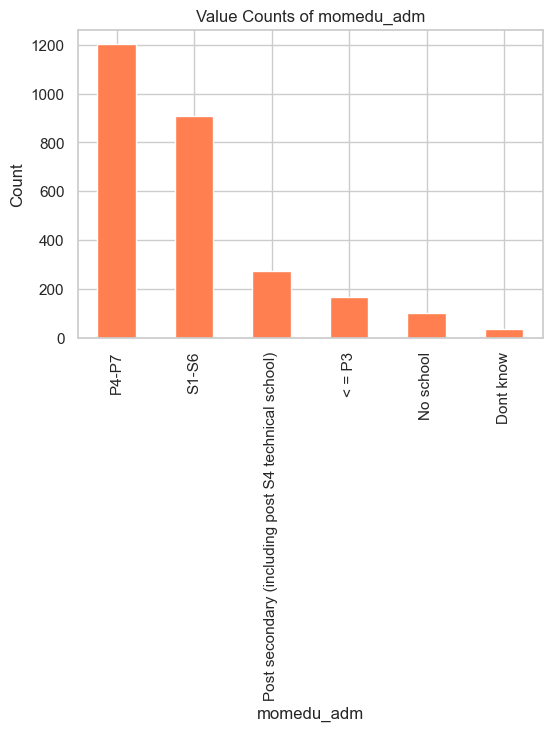

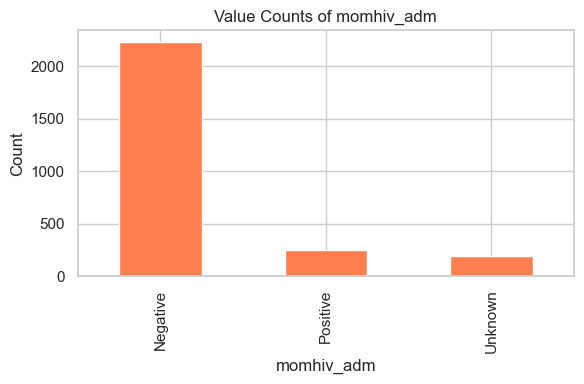

C:\Users\Hermela\AppData\Local\Temp\ipykernel_15664\43101538.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


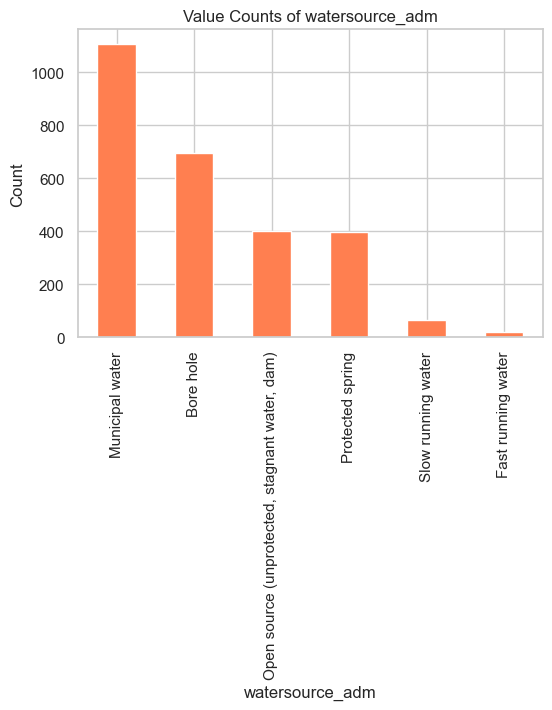

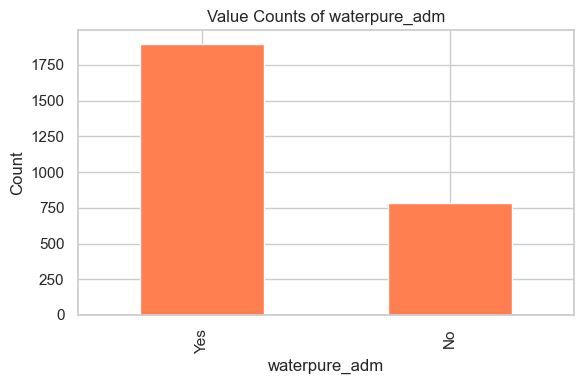

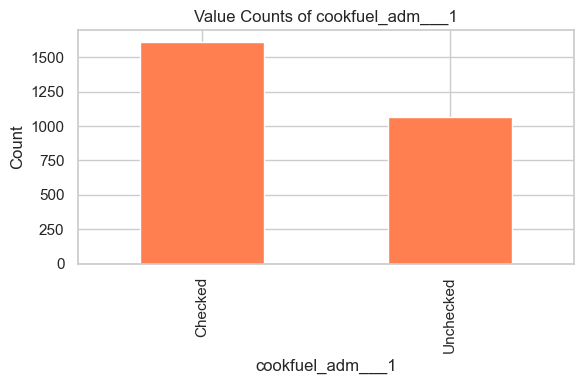

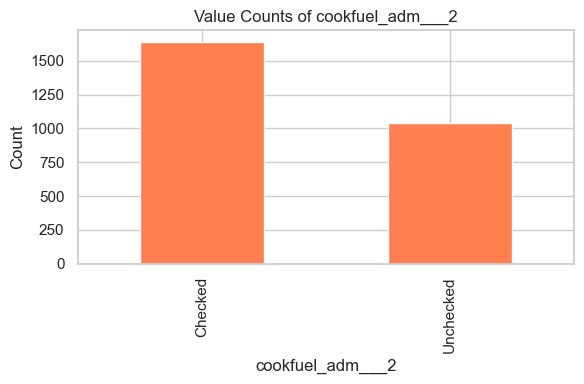

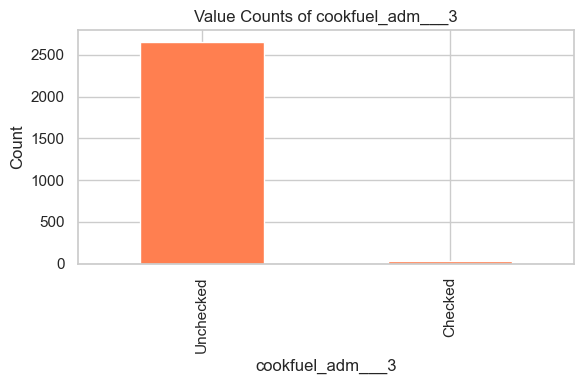

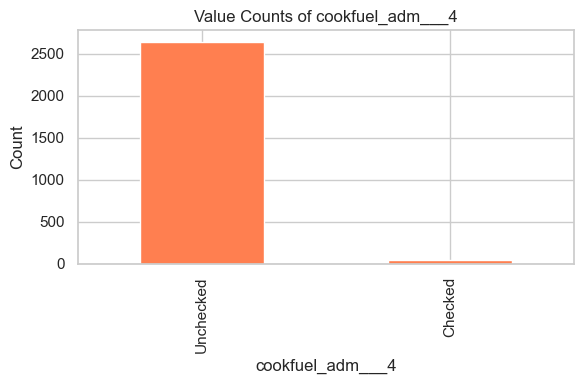

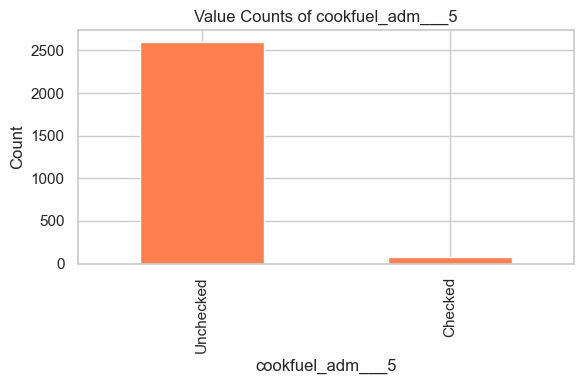

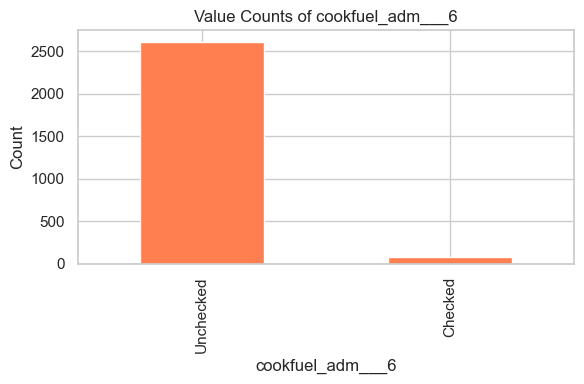

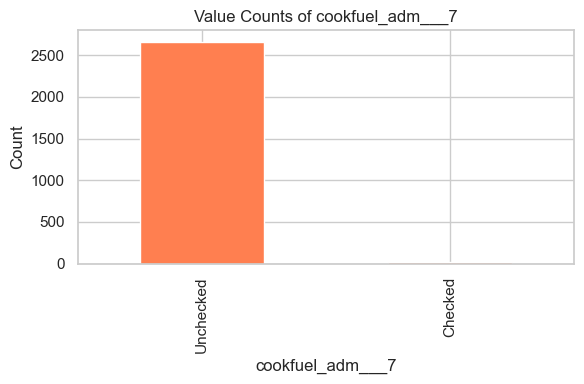

C:\Users\Hermela\AppData\Local\Temp\ipykernel_15664\43101538.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


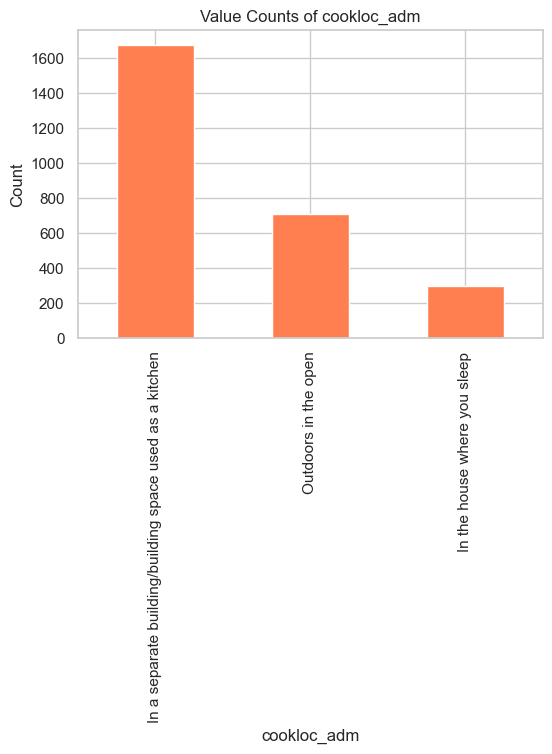

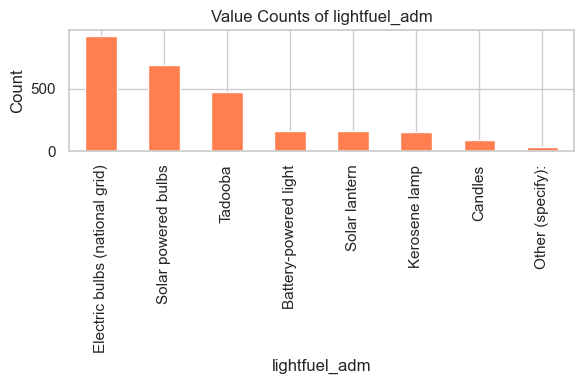

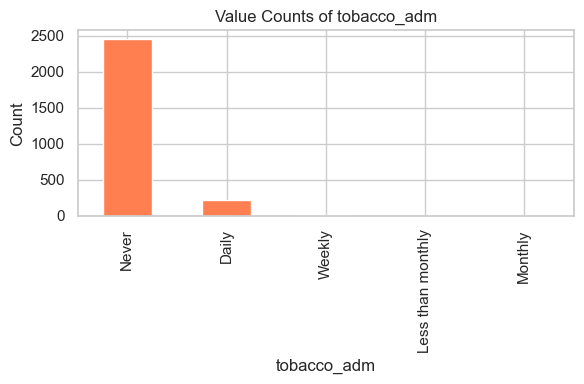

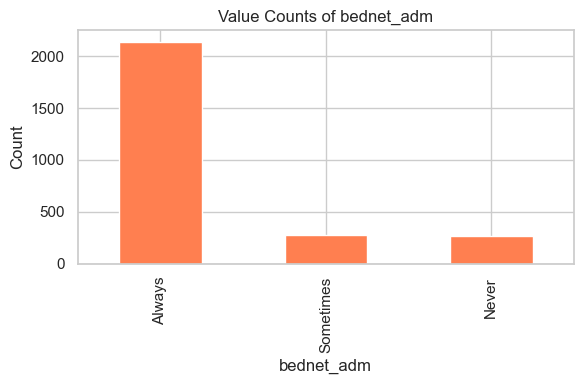

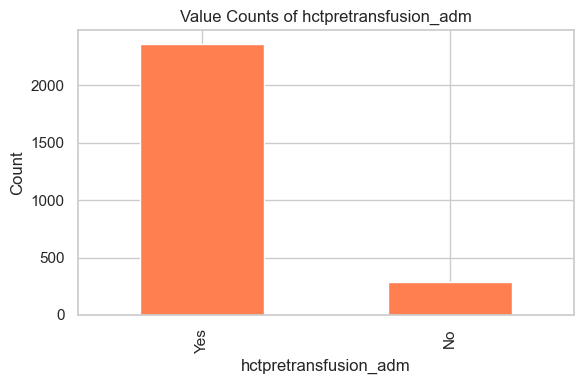

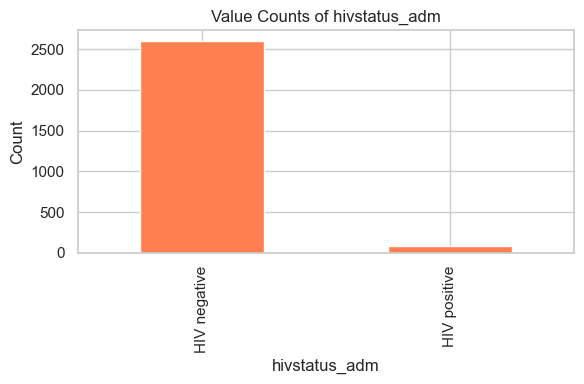

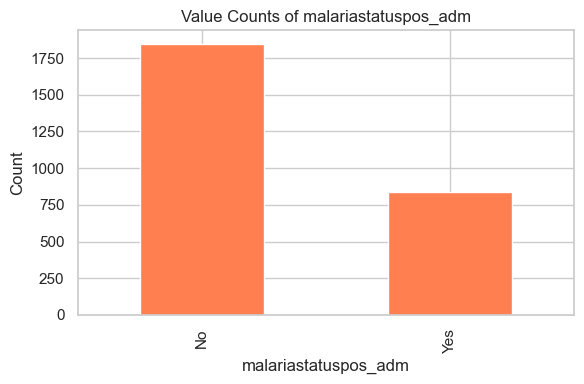

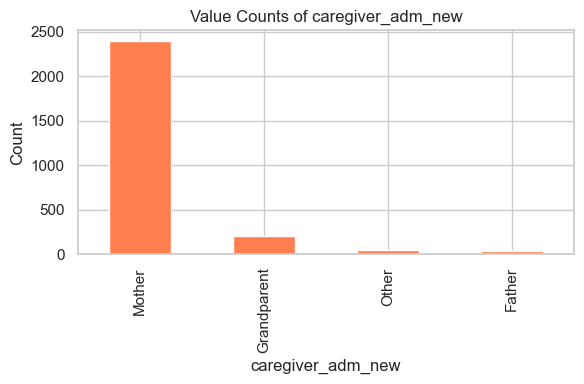

In [23]:
# Select categorical columns
cat_cols = sepsis_df.select_dtypes(include='object').columns

# Plot bar charts for categorical columns
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sepsis_df[col].value_counts().plot(kind='bar', color='coral')
    plt.title(f'Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


In [27]:
# Calculate skewness and kurtosis
from scipy.stats import skew, kurtosis

for col in sepsis_df.select_dtypes(include=['float64', 'int64']).columns:
    print(f"{col}: Skewness = {skew(sepsis_df[col].dropna()):.2f}, Kurtosis = {kurtosis(sepsis_df[col].dropna()):.2f}")


studyid_adm: Skewness = 0.00, Kurtosis = -1.20
agecalc_adm: Skewness = 1.04, Kurtosis = 0.27
height_cm_adm: Skewness = 0.60, Kurtosis = -0.15
weight_kg_adm: Skewness = 0.80, Kurtosis = 0.97
muac_mm_adm: Skewness = -0.42, Kurtosis = 0.63
hr_bpm_adm: Skewness = -0.89, Kurtosis = 1.66
rr_brpm_app_adm: Skewness = 0.76, Kurtosis = 0.64
sysbp_mmhg_adm: Skewness = 0.45, Kurtosis = 1.12
diasbp_mmhg_adm: Skewness = 0.10, Kurtosis = 0.77
temp_c_adm: Skewness = 0.52, Kurtosis = -0.36
spo2site1_pc_oxi_adm: Skewness = -2.41, Kurtosis = 6.89
spo2site2_pc_oxi_adm: Skewness = -2.37, Kurtosis = 6.57
spo2other_adm: Skewness = -1.64, Kurtosis = 2.41
momage_adm: Skewness = 0.56, Kurtosis = -0.24
momagefirstpreg_adm: Skewness = 0.96, Kurtosis = 1.24
householdsize_adm: Skewness = 1.25, Kurtosis = 2.41
alivechildren_adm: Skewness = 1.11, Kurtosis = 1.20
deadchildren_adm: Skewness = 3.66, Kurtosis = 20.69
hematocrit_gpdl_adm: Skewness = -0.21, Kurtosis = 1.26
lactate_mmolpl_adm: Skewness = 2.72, Kurtosis = 10